## 1 Preliminaries

## 1.1 Imports and Configurations

### Imports

In [1]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from pandas.api.types import CategoricalDtype
from typing import List, Dict, Optional, Union
from sklearn.feature_selection import mutual_info_regression
from ydata_profiling import ProfileReport

/home/jaskier/Projects/End to End/predict-calorie-expenditure/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Constants

In [2]:
# 1 Preliminaries

RANDOM_STATE = 42

RAW_TRAIN_PATH = Path("../data/raw/train.csv")
RAW_TEST_PATH = Path("../data/raw/test.csv")

FEATURES_CAT = ["Sex"]

# 2 Feature Utility Scores

MI_SCORES_FEATURE_TO_ESTIMATE = "Calories"

# 3 Feature Engineering

DROP_FEATURES_AFTER_ENGINEERING = (
    "Is_High_BMI",
    "Is_Young",
    "Sex",
    "Age_Group",
)

REPORTS_DIR = Path("../reports/")
REPORTS_DIR.mkdir(exist_ok=True)

### Configs

In [3]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## 1.2 Data Preprocessing

### Read

In [4]:
def read_data(path: Union[str, Path]) -> pd.DataFrame:
    df = pd.read_csv(path, index_col=0)
    return df

In [5]:
df_train = read_data(RAW_TRAIN_PATH)
df_train

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0
...,...,...,...,...,...,...,...,...
749995,male,28,193.0,97.0,30.0,114.0,40.9,230.0
749996,female,64,165.0,63.0,18.0,92.0,40.5,96.0
749997,male,60,162.0,67.0,29.0,113.0,40.9,221.0


In [6]:
df_test = read_data(RAW_TEST_PATH)
df_test

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp
id,,,,,,,
750000,male,45,177.0,81.0,7.0,87.0,39.8
750001,male,26,200.0,97.0,20.0,101.0,40.5
750002,female,29,188.0,85.0,16.0,102.0,40.4
750003,female,39,172.0,73.0,20.0,107.0,40.6
750004,female,30,173.0,67.0,16.0,94.0,40.5
...,...,...,...,...,...,...,...
999995,female,56,159.0,62.0,6.0,85.0,39.4
999996,male,32,202.0,101.0,3.0,84.0,38.4
999997,female,31,164.0,64.0,14.0,98.0,40.1


### Clean

In [7]:
def clean(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop_duplicates()
    return df

In [8]:
df_train_cleaned = clean(df_train)

In [9]:
sum(df_train_cleaned.duplicated())

0

### Missing Values

In [10]:
df_train.isna().sum().sum()

np.int64(0)

In [11]:
df_test.isna().sum().sum()

np.int64(0)

### Encode

In [12]:
def encode(
    df: pd.DataFrame,
    features_cat: Optional[List[str]] = None,
    features_date: Optional[List[str]] = None,
    feature_ord_levels: Optional[Dict[str, List[str]]] = None,
    format: str = "%d-%m-%Y",
) -> pd.DataFrame:

    def encode_cat(df: pd.DataFrame, features_cat: List[str]) -> pd.DataFrame:
        for feature in features_cat:
            if feature in df.columns:
                df[feature] = df[feature].astype("category")
        return df

    def encode_date(df: pd.DataFrame, features_date: List[str]) -> pd.DataFrame:
        for feature in features_date:
            if feature in df.columns:
                df[feature] = pd.to_datetime(
                    df[feature], format=format, errors="coerce"
                )
        return df

    def encode_ord(
        df: pd.DataFrame, feature_ord_levels: Dict[str, List[str]]
    ) -> pd.DataFrame:
        for feature, levels in feature_ord_levels.items():
            if feature in df.columns:
                cat_type = CategoricalDtype(categories=levels, ordered=True)
                df[feature] = df[feature].astype(str).astype(cat_type)
        return df

    if features_cat:
        df = encode_cat(df, features_cat)

    if features_date:
        df = encode_date(df, features_date)

    if feature_ord_levels:
        df = encode_ord(df, feature_ord_levels)

    return df

In [13]:
df_train_encoded = encode(df_train_cleaned, features_cat=FEATURES_CAT)

/tmp/ipykernel_55722/3585337718.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[feature] = df[feature].astype("category")


### Summary

In [14]:
def load_data(
    path: str,
    features_cat: Optional[List[str]] = None,
    features_date: Optional[List[str]] = None,
    feature_ord_levels: Optional[Dict[str, List[str]]] = None,
) -> pd.DataFrame:

    df = read_data(path)
    df = clean(df)

    df = encode(
        df,
        features_cat=features_cat or [],
        features_date=features_date or [],
        feature_ord_levels=feature_ord_levels or {},
        format="%d/%m/%Y",
    )

    return df

In [15]:
df_train_preprocessed = load_data(path=RAW_TRAIN_PATH, features_cat=FEATURES_CAT)
df_train_preprocessed.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
id,,,,,,,,
0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [16]:
df_train_preprocessed.dtypes

Sex           category
Age              int64
Height         float64
Weight         float64
Duration       float64
Heart_Rate     float64
Body_Temp      float64
Calories       float64
dtype: object

## 2 Feature Utility Scores

## 2.1 MI Scores

In [17]:
def make_mi_scores(
    X: pd.DataFrame, y: Union[pd.Series, np.ndarray], random_state: int = 0
) -> pd.Series:
    X = X.copy()
    for feature in X.select_dtypes(["object", "category", "datetime64[ns]"]):
        X[feature], _ = X[feature].factorize()
        X[feature] = X[feature].astype(int).fillna(-1)

    discrete_features: list[bool] = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(
        X, y, discrete_features=discrete_features, random_state=random_state
    )
    mi_scores_series = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    return mi_scores_series.sort_values(ascending=False)

In [18]:
def plot_mi_scores(scores: pd.Series) -> None:
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)

    plt.figure(figsize=(10, 6))
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")
    plt.xlabel("Score")
    plt.tight_layout()
    plt.show()

In [19]:
X_mi = df_train_preprocessed.copy()
y_mi = X_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

mi_scores = make_mi_scores(X_mi, y_mi, random_state=RANDOM_STATE)
mi_scores

Duration      1.638435
Body_Temp     1.119307
Heart_Rate    0.976208
Age           0.095728
Weight        0.054552
Height        0.053719
Sex           0.016690
Name: MI Scores, dtype: float64

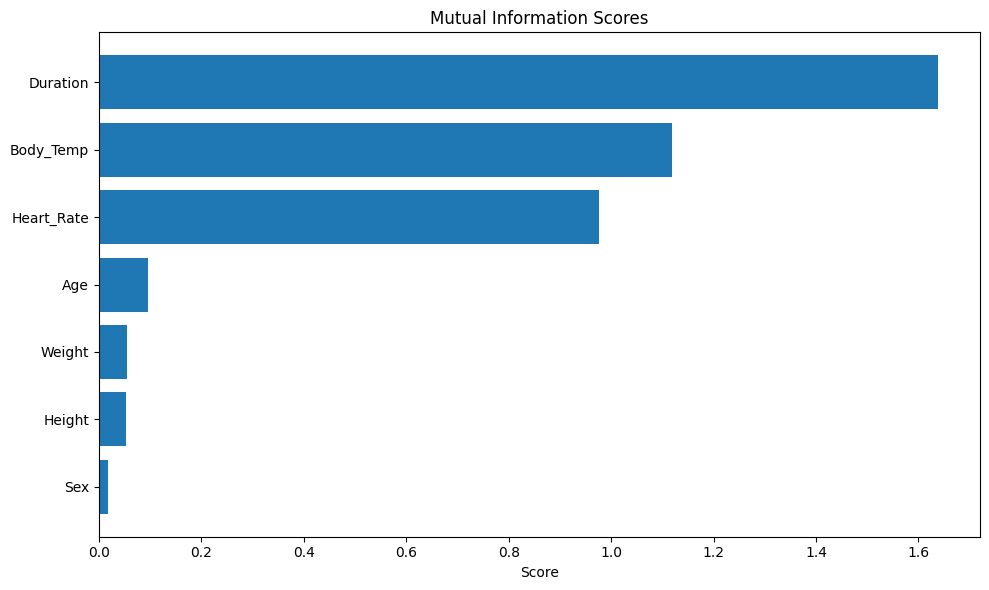

In [20]:
plot_mi_scores(mi_scores)

## 3 Feature Engineering

## 3.1 Binning

In [21]:
def feature_binning(
    df: pd.DataFrame,
    add_age_group: bool = True,
    add_hr_group: bool = True,
    add_duration_group: bool = True,
) -> pd.DataFrame:

    df = df.copy()

    if add_age_group and "Age" in df.columns:
        df["Age_Group"] = pd.cut(
            df["Age"],
            bins=[0, 21, 30, 40, 60, 100],
            labels=["until21", "21-30", "30-40", "40-60", "60-100"],
        )

    if add_hr_group and "Heart_Rate" in df.columns:
        df["Heart_Rate_Group"] = pd.cut(
            df["Heart_Rate"],
            bins=[0, 90, 120, 140, 200],
            labels=["low", "normal", "high", "very_high"],
        )

    if add_duration_group and "Duration" in df.columns:
        df["Duration_Group"] = pd.qcut(
            df["Duration"], q=4, labels=["short", "medium", "long", "very_long"]
        )

    return df

In [22]:
df_train_feature_binning = feature_binning(df_train_preprocessed)

## 3.2 Feature Transformation

In [23]:
def feature_transformation(df: pd.DataFrame) -> pd.DataFrame:

    df = df.copy()

    if "Body_Temp" in df.columns:
        df["Temp_Deviation"] = df["Body_Temp"] - 36.5
        df["Is_Fever"] = (df["Body_Temp"] >= 38.0).astype(int)

    if "Heart_Rate" in df.columns:
        df["Heart_Rate_Deviation"] = df["Heart_Rate"] - 60

    if "Duration" in df.columns:
        df["Log_Duration"] = np.log1p(df["Duration"])
        df["Is_Short_Session"] = (df["Duration"] < 10).astype(int)

    if "Weight" in df.columns:
        df["Log_Weight"] = np.log1p(df["Weight"])

    if "Age" in df.columns:
        df["Log_Age"] = np.log1p(df["Age"])
        df["Is_Young"] = (df["Age"] <= 25).astype(int)

    return df

In [24]:
df_train_feature_transformation = feature_transformation(df_train_feature_binning)

## 3.3 Interactions

In [25]:

def feature_interactions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    if "Weight" in df.columns and "Height" in df.columns:
        df["BMI"] = df["Weight"] / ((df["Height"] / 100) ** 2)
        df["Is_High_BMI"] = (df["BMI"] > 27).astype(int)

    if (
        "Duration" in df.columns
        and "Heart_Rate" in df.columns
        and "Weight" in df.columns
    ):
        df["Calories_Est"] = df["Duration"] * df["Heart_Rate"] * df["Weight"] / 10000
        df["Log_Calories_Est"] = np.log1p(df["Calories_Est"])

    if "Duration" in df.columns and "Heart_Rate" in df.columns:
        df["Effort"] = df["Duration"] * df["Heart_Rate"]
        df["Log_Effort"] = np.log1p(df["Effort"])

    if "Heart_Rate" in df.columns and "Age" in df.columns:
        df["Heart_Rate_Per_Age"] = df["Heart_Rate"] / df["Age"]
        df["Intensity_Index"] = df["Heart_Rate"] / (220 - df["Age"])
        df["Log_Heart_Rate_Per_Age"] = np.log1p(df["Heart_Rate_Per_Age"])

    if "Duration" in df.columns and "Weight" in df.columns:
        df["Effort_Per_Kg"] = df["Duration"] * df["Heart_Rate"] / df["Weight"]
        df["Log_Effort_Per_Kg"] = np.log1p(df["Effort_Per_Kg"])

    if "Duration" in df.columns and "Age" in df.columns:
        df["Duration_Per_Age"] = df["Duration"] / df["Age"]

    return df

In [26]:
df_train_feature_interactions = feature_interactions(df_train_feature_transformation)

## 3.4 MI Scores for New Features

In [27]:
X_new_mi = df_train_feature_interactions.copy()
y_new_mi = X_new_mi.pop(MI_SCORES_FEATURE_TO_ESTIMATE)

new_mi_scores = make_mi_scores(X_new_mi, y_new_mi, random_state=RANDOM_STATE)
new_mi_scores

Log_Effort                1.987827
Effort                    1.986860
Log_Duration              1.640492
Duration                  1.638250
Log_Effort_Per_Kg         1.626991
Effort_Per_Kg             1.626365
Calories_Est              1.612095
Log_Calories_Est          1.611389
Duration_Per_Age          1.401097
Body_Temp                 1.119650
Temp_Deviation            1.119192
Duration_Group            1.073016
Intensity_Index           1.028255
Heart_Rate_Deviation      0.976418
Heart_Rate                0.974740
Heart_Rate_Per_Age        0.880424
Log_Heart_Rate_Per_Age    0.879938
Is_Short_Session          0.519147
Heart_Rate_Group          0.387201
BMI                       0.107317
Age                       0.097676
Log_Age                   0.095213
Is_Fever                  0.073445
Height                    0.054362
Weight                    0.054187
Log_Weight                0.052850
Age_Group                 0.038221
Sex                       0.016694
Is_Young            

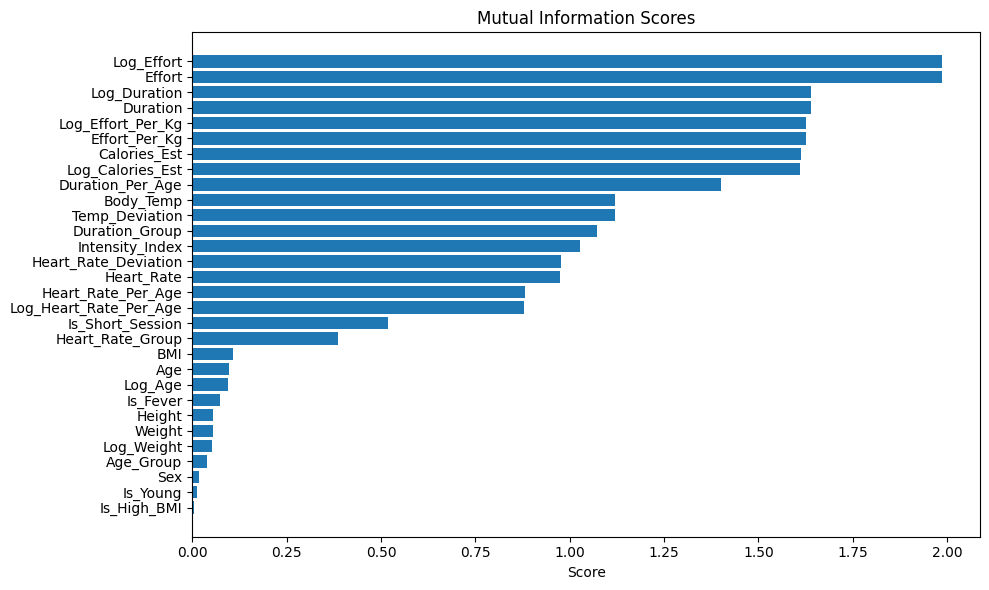

In [28]:
plot_mi_scores(new_mi_scores)

## 3.5 Create Features

In [29]:
def create_features(
    df: pd.DataFrame, drop_features_after_engineering: Union[list, tuple]
) -> pd.DataFrame:

    df = df.copy()

    df = feature_binning(df)
    df = feature_transformation(df)
    df = feature_interactions(df)
    
    features_to_drop = [
        col for col in drop_features_after_engineering if col in df.columns
    ]
    df.drop(columns=features_to_drop, inplace=True)
    df = df.drop_duplicates()

    return df

In [30]:
df_train_feature_engineering = create_features(df_train_preprocessed, drop_features_after_engineering=DROP_FEATURES_AFTER_ENGINEERING)

In [31]:
df_train_feature_engineering.info()

<class 'pandas.core.frame.DataFrame'>
Index: 747102 entries, 0 to 749999
Data columns (total 27 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   Age                     747102 non-null  int64   
 1   Height                  747102 non-null  float64 
 2   Weight                  747102 non-null  float64 
 3   Duration                747102 non-null  float64 
 4   Heart_Rate              747102 non-null  float64 
 5   Body_Temp               747102 non-null  float64 
 6   Calories                747102 non-null  float64 
 7   Heart_Rate_Group        747102 non-null  category
 8   Duration_Group          747102 non-null  category
 9   Temp_Deviation          747102 non-null  float64 
 10  Is_Fever                747102 non-null  int64   
 11  Heart_Rate_Deviation    747102 non-null  float64 
 12  Log_Duration            747102 non-null  float64 
 13  Is_Short_Session        747102 non-null  int64   
 14  Log_Weigh

## 3.6 Feature Engineering Report

In [32]:
profile_report = ProfileReport(df_train_feature_engineering, title="Profile Report")
profile_report.to_file(REPORTS_DIR.joinpath("feature_engineering_report.html"))

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 26.12it/s]
